# Implementation and run with U-Net architecture

In [120]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [121]:
import os
import matplotlib.image as mpimg
import cv2

In [122]:
import unet
import util

In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
def rotate_img(img, angle, rgb):
    rows, cols = img.shape[0:2]
    if rgb:
        id = 1
    else:
        id = 0
    rot_M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, id)
    return cv2.warpAffine(img, rot_M, (cols, rows))

In [125]:
def flip_img(img, border_id):
    return cv2.flip(img, border_id)

In [126]:
def extract_data(filename, num_images, mytype='train'):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting data...')
    imgs = []
    for i in range(1, num_images+1):
        if i%10==0:
            print('Extract original images... i=',i)
        if mytype == 'train':
            imageid = "satImage_%.3d" % i
        else:
            imageid = "test_%.1d" % i
        image_filename = filename + imageid + ".png"
        """print ('Loading ' + image_filename) # TOREMOOOOOOOOOOOOOOOOOOOOOOVE
        img = mpimg.imread(image_filename) # to remove
        #img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA) # to remove
        imgs.append(img) # to remove"""
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
            
            img_cv2 = cv2.imread(image_filename)
            img_flip = np.flip(flip_img(img_cv2, 1),2)/255
            imgs.append(img_flip)
            
            imgs.append(np.flip(rotate_img(img_cv2, 90, True),2)/255)
            imgs.append(np.flip(rotate_img(img_cv2, 180, True),2)/255)
            imgs.append(np.flip(rotate_img(img_cv2, 270, True),2)/255)
            
            if i==2:
                plt.subplot(151),plt.imshow(img),plt.title('Input')
                plt.subplot(152),plt.imshow(np.flip(rotate_img(img_cv2, 90, True),2)/255),plt.title('Output')
                plt.subplot(153),plt.imshow(np.flip(rotate_img(img_cv2, 180, True),2)/255),plt.title('Output')
                plt.subplot(154),plt.imshow(np.flip(rotate_img(img_cv2, 270, True),2)/255),plt.title('Output')
                plt.subplot(155),plt.imshow(img_flip),plt.title('Output')
                plt.show()
        
            
        else:
            print ('File ' + image_filename + ' does not exist')
        
    img_size = imgs[0].shape[0]
    img_height = imgs[0].shape[1]
    if img_size != img_height:
        print('Error!! The images should have their height equal to their width.')

    return np.asarray(imgs).astype(np.float32)

In [127]:
# Assign a label to a patch v
def value_to_class(v):
    # you can remark the hot encoding
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
    df = np.sum(v)
    if df > foreground_threshold:
        return [0, 1]
    else:
        return [1, 0]

In [128]:
# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    print('Extracting labels...')
    gt_imgs = []
    for i in range(1, num_images+1):
        if i%10==0:
            print('Extract groundtruth images... i=',i)
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        """print ('Loading ' + image_filename) # remooooooooooove
        img = mpimg.imread(image_filename) #remoooooooooooooooove
        #img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA) # to remove
        gt_imgs.append(img) # remoooooooove"""
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
            
            img_cv2 = cv2.imread(image_filename,0)
            gt_img_flip = flip_img(img_cv2, 1)/255
            gt_imgs.append(gt_img_flip)
            
            gt_imgs.append(rotate_img(img_cv2, 90, True)/255)
            gt_imgs.append(rotate_img(img_cv2, 180, True)/255)
            gt_imgs.append(rotate_img(img_cv2, 270, True)/255)
            
            if i==2:
                plt.subplot(151),plt.imshow(img),plt.title('Input')
                plt.subplot(152),plt.imshow(rotate_img(img_cv2, 90, True)/255),plt.title('Output')
                plt.subplot(153),plt.imshow(rotate_img(img_cv2, 180, True)/255),plt.title('Output')
                plt.subplot(154),plt.imshow(rotate_img(img_cv2, 270, True)/255),plt.title('Output')
                plt.subplot(155),plt.imshow(gt_img_flip),plt.title('Output')
                plt.show()
            
        else:
            print ('File ' + image_filename + ' does not exist')

    data = np.asarray(gt_imgs)
    out_lab = [[[value_to_class(data[i][j][k]) \
                 for k in range(data.shape[2])] \
                for j in range(data.shape[1])] \
               for i in range(data.shape[0])]

    # Convert to dense 1-hot representation.
    return np.asarray(out_lab).astype(np.float32)

Extracting data...


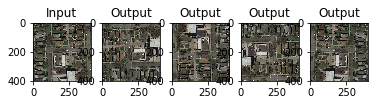

Extract original images... i= 10
Extracting labels...


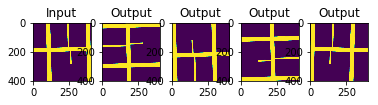

Extract groundtruth images... i= 10


In [129]:
########### define directory of the training images ############################
data_dir = '../training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/'
TRAINING_SIZE = 10

data = extract_data(train_data_filename, TRAINING_SIZE)
labels = extract_labels(train_labels_filename, TRAINING_SIZE)

In [130]:
initial_data = data[range(0,data.shape[0],5)]
initial_labels = labels[range(0,data.shape[0],5)]

In [131]:
print(data.shape)
print(labels.shape)

(50, 400, 400, 3)
(50, 400, 400, 2)


In [132]:
net = unet.Unet(channels=3, n_class=2, layers=5, features_root=4) 
    #, cost_kwargs={'regularizer':1e-4}) # class_weights

2017-12-13 18:53:28,259 Layers 5, features 4, filter size 3x3, pool size: 2x2


In [133]:
# Optimizer = "momentum" or "adam"
trainer = unet.Trainer(net, batch_size=3, optimizer="adam") 
    #, opt_kwargs=dict(momentum=0.2)), learning_rate, decay_rate

In [134]:
path = trainer.train(data=data, labels=labels, output_path="./unet_trained", training_iters=5, \
                     epochs=3, dropout=1.0, display_step=5, prediction_path='prediction')

2017-12-13 18:53:30,433 Removing '/home/zampieri/Documents/EPFL/ML/LMO_ML/project2/project_Luca/unet/prediction'
2017-12-13 18:53:30,435 Removing '/home/zampieri/Documents/EPFL/ML/LMO_ML/project2/project_Luca/unet/unet_trained'
2017-12-13 18:53:30,440 Allocating '/home/zampieri/Documents/EPFL/ML/LMO_ML/project2/project_Luca/unet/prediction'
2017-12-13 18:53:30,448 Allocating '/home/zampieri/Documents/EPFL/ML/LMO_ML/project2/project_Luca/unet/unet_trained'
2017-12-13 18:53:40,982 Verification error= 21.5%, loss= 0.6722
2017-12-13 18:53:42,033 Start optimization
2017-12-13 18:53:44,039 Iter 0, Minibatch Loss= 0.6671, Training Accuracy= 0.8143, Minibatch error= 18.6%


      advance: :  0 %


2017-12-13 18:53:48,882 Epoch 0, Average loss: 0.6643, learning rate: 0.0010
2017-12-13 18:53:59,103 Verification error= 21.5%, loss= 0.6557
2017-12-13 18:54:01,847 Iter 5, Minibatch Loss= 0.6484, Training Accuracy= 0.8145, Minibatch error= 18.6%


      advance: :  0 %


2017-12-13 18:54:06,499 Epoch 1, Average loss: 0.6496, learning rate: 0.0010
2017-12-13 18:54:16,943 Verification error= 21.5%, loss= 0.6380
2017-12-13 18:54:19,718 Iter 10, Minibatch Loss= 0.6356, Training Accuracy= 0.7806, Minibatch error= 21.9%


      advance: :  100 %


2017-12-13 18:54:24,390 Epoch 2, Average loss: 0.6320, learning rate: 0.0010
2017-12-13 18:54:34,522 Verification error= 21.5%, loss= 0.6161
2017-12-13 18:54:35,785 Optimization Finished!


In [117]:
prediction = net.predict(path, data)

INFO:tensorflow:Restoring parameters from ./unet_trained/model.cpkt


2017-12-13 18:51:11,086 Restoring parameters from ./unet_trained/model.cpkt
2017-12-13 18:51:11,664 Model restored from file: ./unet_trained/model.cpkt


(50, 400, 400, 2)


(50, 228, 228, 2)


(228, 228, 6)

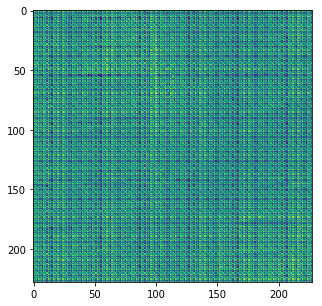

In [118]:
pred = prediction
print(pred.shape)
pred = util.to_rgb(pred[0,:,:,:])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,5))
ax.imshow(pred[:,:,0], aspect="auto")
pred.shape

IndexError: tuple index out of range

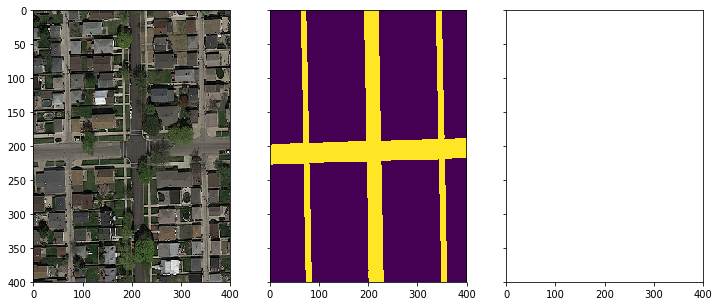

In [73]:
id_end = 5
for num in range(0,id_end):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
    ax[0].imshow(initial_data[num], aspect="auto")
    ax[1].imshow(initial_labels[num,:,:,1], aspect="auto")
    #mask = prediction[num,:,:,1] > 0.5
    pred = prediction[num,:,:,1]
    pred = util.to_rgb(pred[..., 1].reshape(-1, pred.shape[2], 1))
    #ax[2].imshow(mask, aspect="auto")
    ax[2].imshow(pred, aspect="auto")
    ax[0].set_title("Input")
    ax[1].set_title("Ground truth")
    ax[2].set_title("Prediction")
    fig.tight_layout()
    fig.savefig("output/roadSegmentation.png")

In [41]:
img = util.combine_img_prediction(data, labels, prediction)
util.save_image(img, "prediction.jpg")

IndexError: too many indices for array

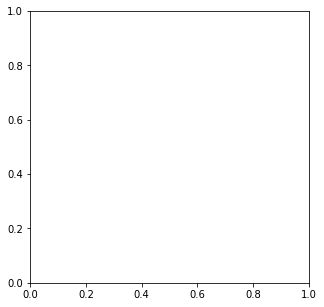

In [39]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,5))
#mask = prediction[num,:,:,1] > 0.5

#ax[2].imshow(mask, aspect="auto")
ax.imshow(img[0,:,:,1], aspect="auto")
ax.set_title("Prediction")
#fig.tight_layout()
#fig.savefig("output/roadSegmentation"+str(num)+".png")

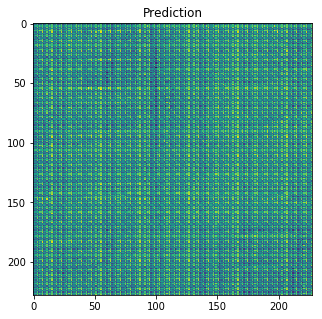

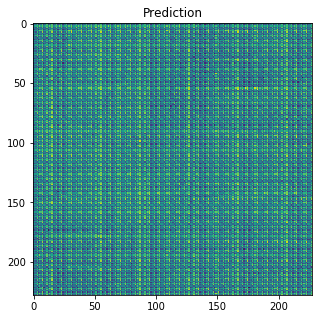

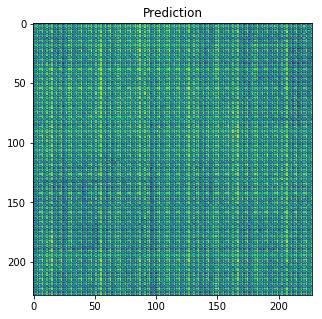

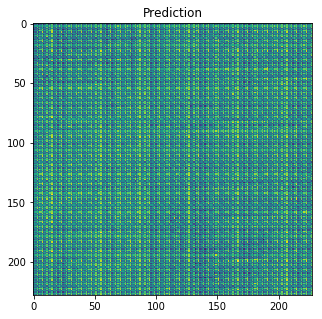

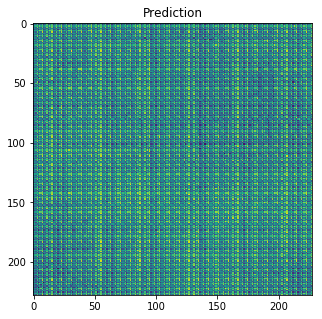

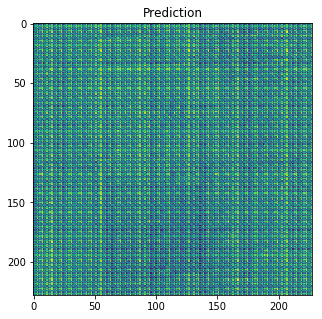

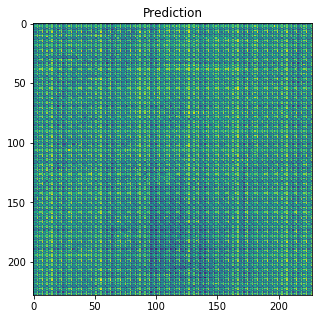

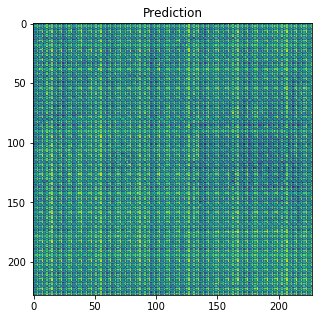

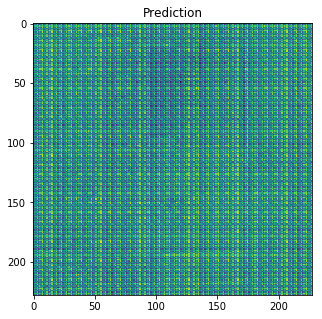

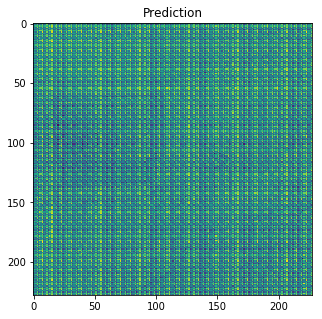

In [119]:
id_end = 10
for num in range(0,id_end):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,5))
    #mask = prediction[num,:,:,1] > 0.5
    
    #ax[2].imshow(mask, aspect="auto")
    ax.imshow(prediction[num,:,:,1], aspect="auto")
    ax.set_title("Prediction")
    #fig.tight_layout()
    fig.savefig("output/roadSegmentation"+str(num)+".png")
